In [19]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix


In [11]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
#if torch.cuda.is_available():
    #device = torch.device("cuda")
    #print("CUDA is available. Using GPU.")
#else:
device = torch.device("cpu")
print("CUDA not available. Using CPU.")

# Model parameters
local_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "kappa_n": 4,
    "num_sigma": 2,
    "kappa_join": 1.0,
    "S_0": 1e-8,
    "c_max": 4,
    "device": device
}
federated_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "c_max": 4,
    "device": device
}

PyTorch Version: 2.1.1
CUDA Version: None
CUDA not available. Using CPU.



*** Start of fold 0. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.5666666666666667, 'precision': 0.41987577639751555, 'recall': 0.5666666666666667, 'f1_score': 0.46476190476190476}
Number of clusters with multiple samples for Client 1 = 6

Training model for client 2
Evolving has been enabled.

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.6, 'precision': 0.44, 'recall': 0.6, 'f1_score': 0.48571428571428577}
Number of clusters with multiple samples for Client 2 = 6

Training model for client 3
Evolving has been enabled.

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9, 'precision': 0.9003663003663004, 'recall': 0.9, 'f1_score': 0.8986666666666666}
Number of clusters with multiple samples for Client 3 = 12

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabl

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: {'accuracy': 0.7, 'precision': 0.7212121212121212, 'recall': 0.7, 'f1_score': 0.7022556390977444}
Number of clusters with multiple samples for Client 4 = 7

Number of clusters after transfer = 31
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9333333333333333, 'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1_score': 0.9333333333333333}

*** Start of fold 1. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.6333333333333333, 'precision': 0.508695652173913, 'recall': 0.6333333333333333, 'f1_score': 0.5367857142857143}
Number of clusters with multiple samples for Client 1 = 4

Training model for client 2
Evolving has been enabled.

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.5666666666666667, 'precision': 0.42272727272727273, 'recall': 0.5666666666666667

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9333333333333333, 'precision': 0.9428571428571428, 'recall': 0.9333333333333333, 'f1_score': 0.9317307692307693}
Number of clusters with multiple samples for Client 4 = 12

Number of clusters after transfer = 34
Number of clusters after merging = 4

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9666666666666667, 'precision': 0.9692307692307692, 'recall': 0.9666666666666667, 'f1_score': 0.9663529411764706}

*** Start of fold 2. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.5666666666666667, 'precision': 0.3782608695652174, 'recall': 0.5666666666666667, 'f1_score': 0.4353535353535353}
Number of clusters with multiple samples for Client 1 = 6

Training model for client 2
Evolving has been enabled.

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accur

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9, 'precision': 0.9299999999999999, 'recall': 0.9, 'f1_score': 0.9}
Number of clusters with multiple samples for Client 3 = 13

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9666666666666667, 'precision': 0.9708333333333333, 'recall': 0.9666666666666667, 'f1_score': 0.9669005847953216}
Number of clusters with multiple samples for Client 4 = 8

Number of clusters after transfer = 33
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9333333333333333, 'precision': 0.9481481481481481, 'recall': 0.9333333333333333, 'f1_score': 0.9337962962962963}

*** Start of fold 3. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: {'accuracy': 0.6, 'precision': 0.5111111111111112, 'recall': 0.6, 'f1_score': 0.5333333333333333}
Number of clusters with multiple samples for Client 1 = 6

Training model for client 2
Evolving has been enabled.

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.8, 'precision': 0.6714513556618819, 'recall': 0.8, 'f1_score': 0.7292250233426704}
Number of clusters with multiple samples for Client 2 = 7

Training model for client 3
Evolving has been enabled.

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Number of clusters with multiple samples for Client 3 = 10

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.8666666666666667, 'precision': 0.8901098901098902, 'recall': 0.8666666666666667, 'f1_score': 0.873015873015873}
Number of clusters with multiple samples f

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9333333333333333, 'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1_score': 0.9333333333333333}
Number of clusters with multiple samples for Client 4 = 11


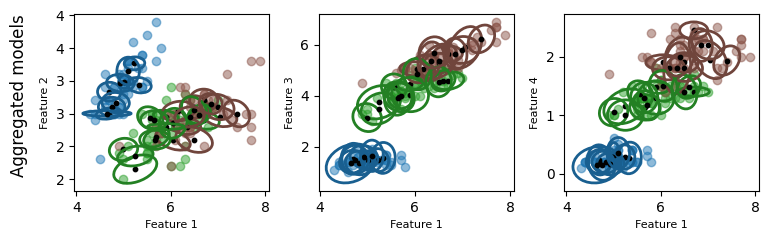

Figure saved as Images/iris_federated_pre_merge.svg in svg format.
Figure saved as Images/iris_federated_pre_merge.pdf in pdf format.

Number of clusters after transfer = 34
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9666666666666667, 'precision': 0.9694444444444444, 'recall': 0.9666666666666667, 'f1_score': 0.9665976535541752}


In [12]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

# Initialize arrays to track samples per class for each client in each fold
samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

# Main loop for k-fold cross-validation
all_client_metrics = [[] for _ in range(num_clients)]
all_client_clusters = [[] for _ in range(num_clients)]

all_federated_metrics = []
all_federated_clusters = []

for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
    print(f"\n*** Start of fold {i_fold}. ***")
    
    #Split the data
    train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)
    
    #Create the models
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)
    #federated_model.toggle_debugging(True)
    
    #Train the models
    for client_idx, client_model in enumerate(local_models):
        
        # Count the number of samples per class for this client in this fold
        for class_idx in range(client_model.num_classes):
            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

        #Supervised clustering
        print(f"\nTraining model for client {client_idx + 1}")
        train_supervised(client_model, train_data[client_idx]) 

        #Test the local models
        print(f"\nTesting model for client {client_idx + 1}")
        _, pred, _ = test_model(client_model, test_data)
        metrics = calculate_metrics(pred, test_data, "weighted")
        print(f"Test Metrics: {metrics}")
        all_client_metrics[client_idx].append(metrics)

        #Save the number of clusters
        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
        all_client_clusters[client_idx].append(num_client_clusters)

    #Aggregate local models
    for client_model in local_models:
        federated_model.federal_agent.merge_model_privately(client_model, 1)
        
    #Plot the Aggregated model
    if i_fold == (num_splits-1):
        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models",format='%d')   
        save_figure(fig, "Images/iris_federated_pre_merge.svg","svg")
        save_figure(fig, "Images/iris_federated_pre_merge.pdf","pdf")

    #Merge the federated model clusters
    print(f"\nNumber of clusters after transfer = {federated_model.c}")
    federated_model.federal_agent.federated_merging()
    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
    print(f"Number of clusters after merging = {federated_model.c}")
    
    #Test the federated model
    print(f"\nTesting federated model")
    _, pred_fed, _ = test_model(federated_model, test_data)
    federated_metrics = calculate_metrics(pred_fed, test_data, "weighted")
    print(f"Test Metrics: {federated_metrics}")
    all_federated_metrics.append(federated_metrics)
    all_federated_clusters.append(num_federated_clusters)

In [13]:
# Calculate the average samples per class for each client
average_samples_per_class_per_client = np.mean(samples_per_class_per_client, axis=2)
print("Average samples per class for each client:")
print(average_samples_per_class_per_client)

# At the end of all folds, calculate and format mean and standard deviation
# Compute and print metrics for each client
for client_idx, client_metrics in enumerate(all_client_metrics):
    formatted_metrics = calculate_metrics_statistics(client_metrics)
    
    print(f"\nMetrics for Client {client_idx + 1} (mean ± std):")
    for metric, value in formatted_metrics.items():
        print(f"{metric}: {value}")

#Calculate evaluation metrics for the federated model
avg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)

print("\nFederated Model - Metrics (mean ± std):")
for metric, value in avg_std_federated_metrics.items():
    print(f"{metric}: {value}")

# Compute and print cluster stats for each client and federated model
for client_idx, client_clusters in enumerate(all_client_clusters):
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    print(f"\nClient {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Compute and print cluster stats for the federated model
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
print(f"\nFederated Model - Average Number of Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")


Average samples per class for each client:
[[ 0.  11.6  8.4]
 [20.8  0.  11. ]
 [ 9.8 18.8  9.6]
 [ 9.4  9.6 11. ]]

Metrics for Client 1 (mean ± std):
accuracy: 0.61 ± 0.06
precision: 0.48 ± 0.08
recall: 0.61 ± 0.06
f1_score: 0.52 ± 0.07

Metrics for Client 2 (mean ± std):
accuracy: 0.65 ± 0.09
precision: 0.49 ± 0.10
recall: 0.65 ± 0.09
f1_score: 0.55 ± 0.11

Metrics for Client 3 (mean ± std):
accuracy: 0.96 ± 0.05
precision: 0.97 ± 0.05
recall: 0.96 ± 0.05
f1_score: 0.96 ± 0.06

Metrics for Client 4 (mean ± std):
accuracy: 0.88 ± 0.11
precision: 0.89 ± 0.10
recall: 0.88 ± 0.11
f1_score: 0.88 ± 0.11

Federated Model - Metrics (mean ± std):
accuracy: 0.95 ± 0.02
precision: 0.95 ± 0.02
recall: 0.95 ± 0.02
f1_score: 0.95 ± 0.02

Client 1 - Average Number of Clusters (mean ± std): 5.40 ± 0.89

Client 2 - Average Number of Clusters (mean ± std): 6.40 ± 0.55

Client 3 - Average Number of Clusters (mean ± std): 11.60 ± 1.14

Client 4 - Average Number of Clusters (mean ± std): 9.80 ± 2.17

Fe

In [20]:
#Create a latex table for the paper
# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{4pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the average samples per class for each client
samples_row = ""
for samples in average_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" if x != 0 else "0" for x in samples])
latex_table += samples_row + " & \\\\" + "\n"

latex_table += r"\midrule" + "\n"
# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['accuracy', 'precision', 'recall', 'f1 score']
for i, metric in enumerate(metrics):
    row = metric_names[i].capitalize() + r' $\uparrow$'
    for client_metrics in all_client_metrics:
        formatted_metric = calculate_metrics_statistics(client_metrics)[metric]
        row += f' & {formatted_metric}'
    fed_formatted_metric = calculate_metrics_statistics(all_federated_metrics)[metric]
    row += r' & \bf'+f'{{{fed_formatted_metric}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in all_client_clusters:
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    cluster_row += f' & {avg_clusters:.1f} ± {std_clusters:.1f}'
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
cluster_row += r' & \bf'+f'{{{avg_fed_clusters:.1f} ± {std_fed_clusters:.1f}}}'
latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


\begin{table}[ht]
\centering
\setlength{\tabcolsep}{4pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
 & 0/11.6/8.4 & 20.8/0/11.0 & 9.8/18.8/9.6 & 9.4/9.6/11.0 & \\
\midrule
Accuracy $\uparrow$ & 0.61 ± 0.06 & 0.65 ± 0.09 & 0.96 ± 0.05 & 0.88 ± 0.11 & \bf{0.95 ± 0.02} \\
Precision $\uparrow$ & 0.48 ± 0.08 & 0.49 ± 0.10 & 0.97 ± 0.05 & 0.89 ± 0.10 & \bf{0.95 ± 0.02} \\
Recall $\uparrow$ & 0.61 ± 0.06 & 0.65 ± 0.09 & 0.96 ± 0.05 & 0.88 ± 0.11 & \bf{0.95 ± 0.02} \\
F1 score $\uparrow$ & 0.52 ± 0.07 & 0.55 ± 0.11 & 0.96 ± 0.06 & 0.88 ± 0.11 & \bf{0.95 ± 0.02} \\
\#Clusters $\downarrow$ & 5.4 ± 0.9 & 6.4 ± 0.5 & 11.6 ± 1.1 & 9.8 ± 2.2 & \bf{3.2 ± 0.4} \\
\bottomrule
\end{tabular}
\end{table}



Client 1: {1: 9, 2: 10}
Client 2: {0: 26, 2: 8}
Client 3: {0: 7, 1: 18, 2: 12}
Client 4: {0: 9, 1: 12, 2: 9}
Test Set: {0: 8, 1: 11, 2: 11}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as Images/iris_data_distribution.svg in svg format.


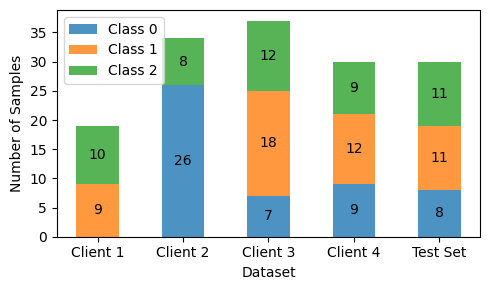

In [15]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/iris_data_distribution.svg","svg")

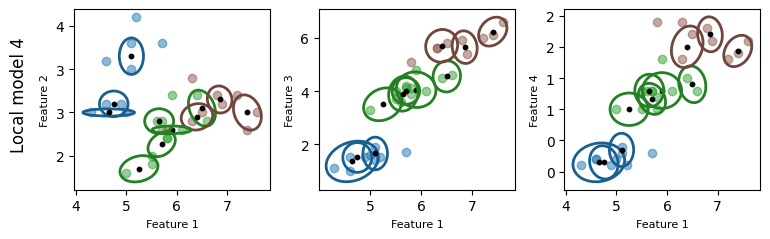

Figure saved as Images/iris_local_model.svg in svg format.
Figure saved as Images/iris_local_model.pdf in pdf format.


In [16]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="Local model 4",format='%d')  
save_figure(fig, "Images/iris_local_model.svg", "svg")
save_figure(fig, "Images/iris_local_model.pdf","pdf")

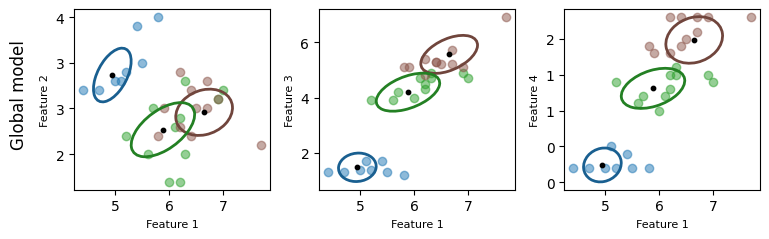

Number of clusters after merging = 3
Figure saved as Images/iris_federated_merged.svg in svg format.
Figure saved as Images/iris_federated_merged.pdf in pdf format.


In [17]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model, num_sigma=2, N_max=0, title="Global model", format='%d')   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, "Images/iris_federated_merged.svg","svg")
save_figure(fig, "Images/iris_federated_merged.pdf","pdf")

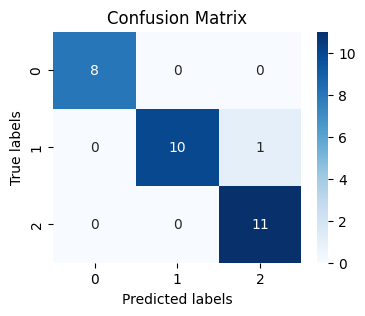

In [18]:
plot_confusion_matrix(pred_fed, test_data)